In [1]:
import torch
import torch.utils.data as data
import torch.nn as nn
from pathlib import Path
from torch.autograd import Variable
import numpy as np

In [2]:
import pandas as pd

def split_dataset_into_train_and_test_pandaframes(metadata_p):
    metadata = pd.read_csv(metadata_p, delimiter='\t')
    train_pf = metadata.loc[metadata['Set'] == 'dev']
    test_pf = metadata.loc[metadata['Set'] == 'test']
    return train_pf, test_pf

In [3]:
def append_audio_files_to_pf(pandaframe, audio_path):
    coefficients_path = "rpcc/"
    list_with_audio_files = []
    
    for index, row in pandaframe.iterrows():
        list_of_audio_files = find_audio_files(row['VoxCeleb1 ID'], audio_path)
        for audio in list_of_audio_files:
            audio_path_parts = str(audio).split('/')
            list_with_audio_files.append([row['VoxCeleb1 ID'], row['Gender'], row['Nationality'], row['Set'], '/'.join(audio_path_parts[4:])])
    return pd.DataFrame(list_with_audio_files, columns = ['VoxCeleb1 ID', 'Gender', 'Nationality', 'Set', 'Audio Path'])
        
def find_audio_files(speaker_id, audio_path):
    audio_path = Path(audio_path)
    return [f for f in audio_path.glob("{}/**/*.wav.npy".format(speaker_id)) if f.is_file()]

In [4]:
metadata_path = "voxceleb1_metadata.csv"
dev_audio_path = "processed/Processed/vox1_dev_wav/wav"
test_audio_path = "processed/Processed/vox1_test_wav/wav"
train_pf, test_pf = split_dataset_into_train_and_test_pandaframes(metadata_path)
train_pf_with_audio_files = append_audio_files_to_pf(train_pf, dev_audio_path)
test_pf_with_audio_files = append_audio_files_to_pf(test_pf, test_audio_path)


In [42]:
frames_lower_than_40 = []
for index, row in train_pf_with_audio_files.iterrows():
    rpcc = np.load("{}/{}".format(dev_audio_path,row['Audio Path']))
        
    if len(rpcc[1]) < 40:
        frames_lower_than_40.append(index)
        
print("Found {} with less than 40 Frames, removing them from train set".format(len(frames_lower_than_40)))

train_pf_with_audio_files = train_pf_with_audio_files.drop(index=frames_lower_than_40)

VoxCeleb1 ID                              id10002
Gender                                          m
Nationality                                 India
Set                                           dev
Audio Path      id10002/cMGEuZ1zqXk/00004.wav.npy
Name: 80, dtype: object
Found 0 with less than 40 Frames, removing them from train set


In [6]:
frames_lower_than_40 = []
for index, row in test_pf_with_audio_files.iterrows():
    full_audio_path = "{}/{}".format(test_audio_path, row['Audio Path'])
   # print(full_audio_path)
    rpcc = np.load(full_audio_path)
        
    if len(rpcc[1]) < 40:
        frames_lower_than_40.append(index)

print("Found {} with less than 40 Frames, removing them from train set".format(len(frames_lower_than_40)))

test_pf_with_audio_files = test_pf_with_audio_files.drop(index=frames_lower_than_40)


Found 0 with less than 40 Frames, removing them from train set


In [7]:
train_speaker_ids = (train_pf_with_audio_files['VoxCeleb1 ID'].unique()).tolist()
validate_speaker_ids = (test_pf_with_audio_files['VoxCeleb1 ID'].unique()).tolist()
speaker_list_ids = train_speaker_ids + validate_speaker_ids

In [8]:
speaker_id_to_index = {}
speaker_index_to_id = {}
for idx, speaker_id in enumerate(speaker_list_ids):
    speaker_id_to_index[speaker_id] = idx
    speaker_index_to_id[idx] = speaker_id

In [9]:
class VoxCelebDataset(data.Dataset):
    def __init__(self, pandaframe, targets, root_dir):
        self.dataset = pandaframe
        self.targets = targets
        self.root_dir = root_dir
        self.len = len(pandaframe)
        
    def __getitem__(self, index):
        speaker = self.dataset.iloc[index]
        path_to_rpcc = "{}/{}".format(self.root_dir, speaker['Audio Path'])
        rpcc = np.load(path_to_rpcc)
        #return 
        return torch.Tensor(rpcc[:,0:40]), speaker['VoxCeleb1 ID']
    
    def __len__(self):
        return self.len

In [10]:
train_dataset = VoxCelebDataset(train_pf_with_audio_files, speaker_id_to_index, dev_audio_path)
test_dataset = VoxCelebDataset(test_pf_with_audio_files, speaker_id_to_index, test_audio_path)

In [11]:
batch_size = 100
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=True)

# data, target = next(iter(dataloader))
# print(data)

In [14]:
import torch.nn.functional as F
import torch.autograd as autograd

class LSTM(nn.Module):
    def __init__(self, coefficients, hidden_dim, speaker_size, label_size, batch_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.lstm = nn.LSTM(coefficients, hidden_dim)
        self.hidden2label = nn.Linear(hidden_dim, speaker_size)
        self.hidden = self. init_hidden()
#         self.lstm = nn.LSTM(input_size, hidden_layer_size)

#         self.l_out = nn.Linear(in_features=3000,
#                                out_features=speaker_size)

    def init_hidden(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(1, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(1, self.batch_size, self.hidden_dim).cuda()))

    def forward(self, x):

        #x = sentence.view(len(sentence), self.batch_size , -1)
        
        #print(x.shape)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y  = self.hidden2label(lstm_out[-1])
        #log_probs = F.log_softmax(y)
        return y

In [15]:
model = LSTM(coefficients=40, hidden_dim=4, speaker_size=len(speaker_index_to_id),label_size=len(speaker_index_to_id), batch_size=batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
model = model.cuda()

In [18]:
epochs = 10

training_loss, validation_loss = [], []


for i in range(epochs):
    
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    model.train()
    
    for idx, (data_train, targets_train) in enumerate(train_dataloader):
        model.batch_size = len(data_train)
        model.hidden = model.init_hidden()
        
        targets_idx = [speaker_id_to_index[speaker_id] for speaker_id in targets_train]
        
        targets_idx = torch.LongTensor(targets_idx)
        
        data_train = data_train.cuda()
        targets_idx = targets_idx.cuda()
        #print(data.shape)
        data_train = data_train.permute(1,0,2)
        #print(data.shape)
        outputs = model.forward(data_train)
        loss = criterion(outputs, targets_idx)
        
        loss.backward()
        optimizer.step()
        
        epoch_training_loss += loss.cpu().detach().numpy()  
    
    model.eval()
    
    for idx, (data_validate, targets_validate) in enumerate(test_dataloader):
        
        model.batch_size = len(data_validate)
        model.hidden = model.init_hidden()
        #print(data.shape)
        data_validate = data_validate.permute(1,0,2)
        data_validate = data_validate.cuda()
        
        
        outputs = model.forward(data_validate)
        
        targets_idx = [speaker_id_to_index[speaker_id] for speaker_id in targets_validate]
        targets_idx = torch.LongTensor(targets_idx)
        targets_idx = targets_idx.cuda()
        
        loss = criterion(outputs, targets_idx)
        
        # Update loss
        epoch_validation_loss += loss.cpu().detach().numpy()    
    
    training_loss.append(epoch_training_loss/len(train_dataloader))
    validation_loss.append(epoch_validation_loss/len(test_dataloader))

    print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


Epoch 0, training loss: 7.06932917103001, validation loss: 11.386523908498337
Epoch 1, training loss: 7.089495586082289, validation loss: 14.766786030360631
Epoch 2, training loss: 7.107071005584573, validation loss: 17.816991494626414
Epoch 3, training loss: 7.117496122669356, validation loss: 20.12984003339495
Epoch 4, training loss: 7.118825798316858, validation loss: 22.37396177953603
Epoch 5, training loss: 7.116270257709967, validation loss: 24.966650359484614
Epoch 6, training loss: 7.1132678709819, validation loss: 27.1500771970165
Epoch 7, training loss: 7.112040803507822, validation loss: 30.160870999706034
Epoch 8, training loss: 7.1081543215666345, validation loss: 32.6421949814777
Epoch 9, training loss: 7.118056040445109, validation loss: 34.39792337222975


In [19]:
trials = pd.read_csv('voxceleb_verification_test.csv', delimiter=' ', names=['Target', 'Trial file 1', 'Trial file 2'])

In [20]:
print(trials.iloc[0])

Target                                      1
Trial file 1    id10270/x6uYqmx31kE/00001.wav
Trial file 2    id10270/8jEAjG6SegY/00008.wav
Name: 0, dtype: object


In [22]:
trials_results = pd.DataFrame(columns=['Targettype', 'Actual target', 'audio_file', 'Score for actual'])

for index, trial in trials.iterrows():
    trial_rpcc = np.load("{}/{}.npy".format(test_audio_path, trial['Trial file 2']))
#trial_rpcc = np.load("{}/{}.npy".format(test_audio_path, trial['Trial file 2']))
    
    trial_rpcc = torch.tensor(trial_rpcc[:,:40]).unsqueeze(0)

    model.batch_size = len(trial_rpcc)
    model.hidden = model.init_hidden()


    trial_rpcc = trial_rpcc.permute(1,0,2)

    trial_rpcc = trial_rpcc.cuda()

    output = model.forward(trial_rpcc)
    
    
    _, result = torch.max(output,1)

    result = result.cpu().detach().numpy()[0]
    speaker_result = speaker_index_to_id[result]
    
    trial_actual_target = str(trial['Trial file 1']).split('/')[0]
    speaker_actual = speaker_id_to_index[trial_actual_target]
    
    result_actual = output.cpu().detach().numpy()[0][speaker_actual]
    
    new_row = {'Targettype': trial['Target'], 'Actual target': trial_actual_target, 'audio_file': trial['Trial file 2'], 'Score for actual': result_actual}
    #print(new_row)
    
    trials_results = trials_results.append(new_row, ignore_index=True)

# print(speaker_result)
# print(trial_actual_target)

In [123]:
print(trials_results)

      Targettype Actual target                     audio_file  \
0              1       id10270  id10270/8jEAjG6SegY/00008.wav   
1              0       id10270  id10300/ize_eiCFEg0/00003.wav   
2              1       id10270  id10270/GWXujl-xAVM/00017.wav   
3              0       id10270  id10273/0OCW1HUxZyg/00001.wav   
4              1       id10270  id10270/8jEAjG6SegY/00022.wav   
...          ...           ...                            ...   
37715          0       id10309  id10302/K2_D_tFdAgY/00036.wav   
37716          1       id10309  id10309/0b1inHMAr6o/00010.wav   
37717          0       id10309  id10289/8l5ZnDf-FUA/00012.wav   
37718          1       id10309  id10309/rxnN8thYzEQ/00017.wav   
37719          0       id10309  id10296/Y-qKARMSO7k/00001.wav   

       Score for actual  
0            -15.295091  
1            -15.295091  
2            -15.295091  
3            -15.295091  
4            -15.295091  
...                 ...  
37715        -16.077700  
37716      

0.3606224060058594
0.6073827743530273
0.4948730145162692


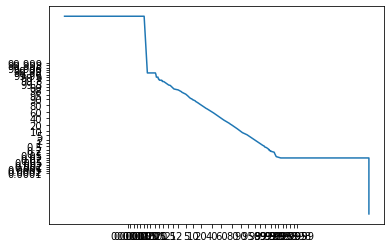

In [41]:
import bob.measure as bm

positives = trials_results.loc[trials_results['Targettype'] == 1]
negatives = trials_results.loc[trials_results['Targettype'] == 0]

#neg_array = negatives['Score for actual']
#print(neg_array)
print(np.max(positives['Score for actual']))
print(np.max(negatives['Score for actual']))
eer=bm.eer_rocch(negatives['Score for actual'], positives['Score for actual'])
print(eer)
bm.plot.det(negatives['Score for actual'],positives['Score for actual'])

In [66]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
lstm.weight_ih_l0 	 torch.Size([16, 40])
lstm.weight_hh_l0 	 torch.Size([16, 4])
lstm.bias_ih_l0 	 torch.Size([16])
lstm.bias_hh_l0 	 torch.Size([16])
hidden2label.weight 	 torch.Size([1251, 4])
hidden2label.bias 	 torch.Size([1251])


In [67]:
torch.save(model.state_dict(), 

In [68]:
torch.save(model, "first_iteration")


/home/tellurium/anaconda3/envs/python3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
